In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np 


Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import torch
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.linalg as slin
import scipy.sparse as sp
import networkx as nx
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import re
import math
from torch.optim.adam import Adam
from utils import *
from statistics import mean
import random

## create data for lag-1 scenario

In [3]:
def simulate_lsem_dynamic(W_all,Z: nx.DiGraph,
                 n: int,n_time:int, treatment_type: str,
                 noise_scale: float = 0.5,
                 baseline: float = 1.0) -> np.ndarray:
    """Simulate samples from LSEM.
        
        Args:
        W_all,A: weigthed DAG for instaneous relation and lagged relation
        n: number of samples in each time-stamp
        lag: degree of AR
        n_time: number of time stamp
        treatment_type: the type of the exposure {Binary, Gaussian}
        noise_scale: noise scale parameter of Gaussian distribution in the lSEM
        baseline: the baseline for the outcome
        
        Returns:
        X: [time,n, d] sample matrix
        """
    #W_array = nx.to_numpy_array(W)
    Z_array = nx.to_numpy_array(Z)
    d = Z_array.shape[0]
    #X_all = np.zeros([n_time+1,n, d])
    
    ## create the initial data
    X = np.zeros([n, d])
    W_0=W_all[0,:,:]
    ordered_vertices = list(nx.topological_sort(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph)))
    assert len(ordered_vertices) == d
    rank_A = ordered_vertices.index(0)
    for j in ordered_vertices:
        if ordered_vertices.index(j) > rank_A:
            parents = list(nx.from_numpy_matrix(W_0,create_using=nx.DiGraph).predecessors(j))
            X[:, j] = X[:, parents].dot(W_0[parents, j]) + np.random.normal(scale=noise_scale, size=n)
        elif ordered_vertices.index(j) < rank_A:
            X[:, j] = np.random.normal(scale=noise_scale, size=n)
        else:
            if treatment_type == 'Binary':
                X[:, j] = 2 * (np.random.binomial(1, 0.5, n) - 0.5)
            elif treatment_type == 'Gaussian':
                X[:, j] = np.random.normal(scale=noise_scale, size=n)
            else:
                raise ValueError('unknown exposure type')
    X[:, d-1] += baseline
    X_all=X
    ## for follow-up time-stamps, X=XW+AZ+E
    for time in range(1,n_time+1):
        X_temp = np.matmul(X,Z_array)
        W_array=W_all[time,:,:] ## different index!
        W=nx.from_numpy_matrix(W_array,create_using=nx.DiGraph)
        for j in ordered_vertices:
            if ordered_vertices.index(j) > rank_A:
                parents = list(W.predecessors(j))
                X_temp[:, j] += X_temp[:, parents].dot(W_array[parents, j]) + np.random.normal(scale=noise_scale, size=n)
            elif ordered_vertices.index(j) < rank_A:
                X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
            else:
                if treatment_type == 'Binary':
                    X_temp[:, j] += 2 * (np.random.binomial(1, 0.5, n) - 0.5)
                elif treatment_type == 'Gaussian':
                    X_temp[:, j] += np.random.normal(scale=noise_scale, size=n)
                else:
                    raise ValueError('unknown exposure type')
        X_all=np.append(X_all,X_temp,axis=0)
        X=X_temp
    return X_all

In [4]:
W_all=np.zeros([11,5, 5])
import math 
def cos(x):
    return(math.cos(x/4*math.pi)*0.8)
for i in range(11):
    W_all[i,0,4]=cos(i)

In [5]:
## create Z matrix
Z=np.identity(5)
Z[0,0]=0 # no correlation for treatment
Z_graph=nx.from_numpy_matrix(Z,create_using=nx.DiGraph)

In [6]:
simulate_lsem_dynamic(W_all,Z_graph,30,10, 'Binary',noise_scale=0.1).shape

(330, 5)

## create basis & function demo

In [7]:
np.random.seed(1234567)

t: [ 0.   0.   0.   2.5  5.   7.5 10.  10.  10. ]
c: [ 0.80503855  0.63664798 -1.24180941  0.23603435  1.10322222 -0.02194516
  0.          0.          0.        ]
k: 2



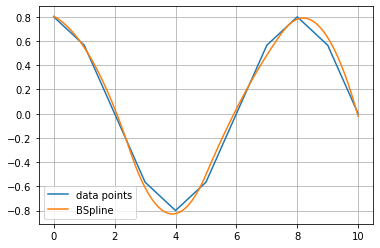

In [8]:
degree =2
x = np.array(range(0, 11))
y = np.array([cos(i) for i in x])
z= [cos(i/10) for i in np.array(range(0, 110))]
m = 3
step = (x[-1] - x[0]) / (m + 1)
knots = np.linspace(step, m * step, m)

t, c, k = interpolate.splrep(x, y, k=degree, s=0, t=knots, per=0)

print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

plt.plot(x, y, label='data points')
plt.plot(xx, spline(xx), label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

In [9]:
from scipy.interpolate import BSpline
k = 2
t = t
c1 = [1,0,0,0,0,0]
c2 = [0,1,0,0,0,0]
c3 = [0,0,1,0,0,0]
c4 = [0,0,0,1,0,0]
c5 = [0,0,0,0,1,0]
c6 = [0,0,0,0,0,1]
spl1 = BSpline(t, c1, k)
spl2 = BSpline(t, c2, k)
spl3 = BSpline(t, c3, k)
spl4 = BSpline(t, c4, k)
spl5 = BSpline(t, c5, k)
spl6 = BSpline(t, c6, k)

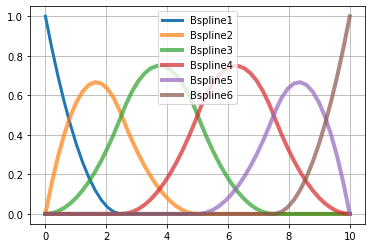

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xx = np.linspace(0, 10, 50)
ax.plot(xx, spl1(xx), lw=3, label='Bspline1')
ax.plot(xx, spl2(xx), lw=4, alpha=0.7, label='Bspline2')
ax.plot(xx, spl3(xx), lw=4, alpha=0.7, label='Bspline3')
ax.plot(xx, spl4(xx), lw=4, alpha=0.7, label='Bspline4')
ax.plot(xx, spl5(xx), lw=4, alpha=0.7, label='Bspline5')
ax.plot(xx, spl6(xx), lw=4, alpha=0.7, label='Bspline6')
ax.grid(True)
ax.legend(loc='best')
plt.show()

# new method

In [11]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import pickle
import os
import random
import torch.optim as optim
from torch.optim import lr_scheduler
import math
from utils import *

from multiprocessing import Pool
import multiprocessing
n_cores = multiprocessing.cpu_count()
from numpy.random import randn
from random import seed as rseed
from numpy.random import seed as npseed
import time

In [12]:
# ----------- Configurations:
time_stamp=10
n_timestamp=time_stamp
sample__time=30##sample per timepoint
n = time_stamp*sample__time # The number of samples of data.
n_var = 5 # The number of variables in data.
x_dims = 1 # The number of input dimensions: default 1.
z_dims = n_var # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.


In [13]:
n_timestamp

10

In [14]:
sample__time

30

In [15]:
def create_D(X,spline_list):
    D_all=np.zeros((sample__time*time_stamp, n_var*len(spline_list),1))
    for j in range(len(spline_list)):
        D_column=np.zeros((sample__time*time_stamp, n_var,1))#for each spline
        for i in range(0,n_timestamp):
            D_column[(sample__time*i):(sample__time*(i+1)),:,:]=X[(sample__time*i):(sample__time*(i+1)),:]*spline_list[j](i)#X_i *f(i), stack horizontally
        ##horizontally append
        D_all[:,n_var*j:n_var*(j+1),:]=D_column
        #print((n_features*j,n_features*(j+1)))
    return(D_all)

In [16]:
#spline_list=[spl_const]
spline_list=[spl1,spl2,spl3,spl4,spl5,spl6]

In [17]:
def spl_consraint(spline_list,t,p):
    k=len(spline_list)
    output=torch.zeros(((p*k), p))
    identity=torch.zeros((p, p*k))
    for i in range(k):
        output[(i*p):(i*p+p),:]=torch.ones((p,p))*spline_list[i](t).item() #gamma times basis
        identity[:,(i*p):(i*p+p)]=torch.eye(p) #stacked identity matrix
    #final=torch.matmul(identity,output)
    return output, identity

In [18]:
# ----------- Configurations:
n = 30*time_stamp # The number of samples of data.
d = 36 # The number of variables in data after spline.  (p+1*k)
x_dims = 1 # The number of input dimensions: default 1.
z_dims = d # The number of latent variable dimensions: default the same as variable size.
epochs = 200 # Number of epochs to train.
batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
k_max_iter = int(1e2) # The max iteration number for searching parameters.
original_lr = 3e-3  # Initial learning rate.
encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
temp = 0.5 # Temperature for Gumbel softmax.
factor = True # Factor graph model.
encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
tau_B = 0. # Coefficient for L-1 norm of matrix B.
lambda1 = 0. # Coefficient for DAG constraint h1(B).
lambda2 = 0. # Coefficient for identification constraint h2(B).
c_B = 1 # Coefficient for absolute value h1(B).
d_B = 1 # Coefficient for absolute value h2(B).
e_B = 1 # Coefficient for absolute value h3(B)
h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
gamma = 1.0 # LR decay factor. 

In [19]:
###edited to remove the first column in the lagged weigttsv
def fun_h2_B_new(B):
    '''compute constraint h2(B) value'''
    d = B.shape[0]
    gamma=B[p:(p+p*k),:p]
    Tau=B[(p+p*k):,:]
    h3_B = sum(sum(abs(B[:p, :])))+sum(abs(gamma[:, 0]))+sum(sum(abs(B[p:, p:])))+ sum(abs(Tau[:, 0]))# uppper 0 and 0 column and every p-1,2p-1 row
    for i in range(k):
        h3_B=h3_B+sum(abs(gamma[((i+1)*p-1), 1:]))
    return h3_B

In [20]:
def fun_h1_B(B):
    '''compute constraint h1(B) value'''
    d = B.shape[0]
    expm_B = matrix_poly(B * B, d)
    h1_B = torch.trace(expm_B) - d
    return h1_B.float()

In [21]:
def train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p,k):
        
        nll_train = []
        kl_train = []
        mse_train = []
        encoder.train()
        decoder.train()
        scheduler.step()

        # Update optimizer
        optimizer, lr = update_optimizer(optimizer, old_lr, c_B, d_B)

        for batch_idx, (data, relations) in enumerate(train_loader):

            data, relations = Variable(data).double(), Variable(relations).double()
            relations = relations.unsqueeze(2) # Reshape data

            optimizer.zero_grad()

            enc_x, logits, origin_B, adj_A_tilt_encoder, z_gap, z_positive, myA, Wa = encoder(data, rel_rec, rel_send) 
            edges = logits # Logits is of size: [num_sims, z_dims]

            dec_x, output, adj_A_tilt_decoder = decoder(data, edges, d * x_dims, rel_rec, rel_send, origin_B, adj_A_tilt_encoder, Wa)

            if torch.sum(output != output):
                print('nan error\n')

            target = data
            preds = output
            variance = 0.
            
            # Compute constraint functions h1(B) and h2(B)
            #h1_B = fun_h1_B(origin_B[p:,p:]) #acyclity on G
            h1_B =0
            for i in range(n_timestamp):
                #aa=torch.matmul(spl_consraint(spline_list,i,p).type(torch.FloatTensor),origin_B[p:,:p].type(torch.FloatTensor))#acyclity on Gamma
                #print(fun_h1_B(aa))
                output, identity=spl_consraint(spline_list,i,p)
                h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*origin_B[p:(p+p*k),:p].type(torch.FloatTensor))))#acyclity on Gamma
            h2_B = fun_h2_B_new(origin_B) ##handle the zero on gamma and top
            # Reconstruction accuracy loss:
            loss_nll = nll_gaussian(preds, target, variance)
            # KL loss:
            loss_kl = kl_gaussian(logits)
            # ELBO loss:
            loss = loss_kl + loss_nll
            # Loss function:
            loss += lambda1 * h1_B + 0.5 * c_B * h1_B * h1_B + lambda2 * h2_B + 0.5 * d_B * h2_B * h2_B + 100. * torch.trace(origin_B * origin_B)

            loss.backward()
            loss = optimizer.step()

            myA.data = stau(myA.data, tau_B * lr)

            if torch.sum(origin_B != origin_B):
                print('nan error\n')

            mse_train.append(F.mse_loss(preds, target).item())
            nll_train.append(loss_nll.item())
            kl_train.append(loss_kl.item())

        return np.mean(np.mean(kl_train) + np.mean(nll_train)), np.mean(nll_train), np.mean(mse_train), origin_B, optimizer, lr


In [22]:
n_var=5
n_times=30 #no. of replicates
time_stamp=10 #no. of timestamp
np.random.seed(1234567) #Random seed
seed_list=np.random.randint(1, 1000000, size=n_times)
average_coef_list_new=np.zeros((n_times,time_stamp,n_var,n_var))
lambda_list=np.zeros((n_times,30,n_var))
t_list=np.zeros((n_times,30,n_var))
for replicate in range(21,n_times):
  seed=seed_list[replicate]
  X_all=simulate_lsem_dynamic(W_all,Z_graph,30,10, 'Binary',noise_scale=0.1).reshape(330,5,1) #create data
  D=create_D(X_all[30:],spline_list)
  G=create_D(X_all[:-30],spline_list)
  data_all=np.append(X_all[30:],D, axis=1)
  data_all=np.append(data_all,G, axis=1)
  print(np.shape(data_all))
  average_list=np.zeros((time_stamp,n_var, n_var))
  
  ####estimate at each time_stamp####
  timestart_new=time.time()
    # ----------- Configurations:
  # ----------- Configurations:
  n = 30*time_stamp # The number of samples of data.
  d = 65 # The number of variables in data after basis.
  x_dims = 1 # The number of input dimensions: default 1.
  z_dims = d # The number of latent variable dimensions: default the same as variable size.
  epochs = 200 # Number of epochs to train.
  batch_size = 10 # Number of samples per batch. note: should be divisible by sample size, otherwise throw an error.
  k_max_iter = int(1e2) # The max iteration number for searching parameters.
  original_lr = 3e-3  # Initial learning rate.
  encoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  decoder_hidden = d^2 # Number of hidden units, adaptive to dimension of nodes (d^2).
  temp = 0.5 # Temperature for Gumbel softmax.
  factor = True # Factor graph model.
  encoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  decoder_dropout = 0.0 # Dropout rate (1 - keep probability).
  tau_B = 0. # Coefficient for L-1 norm of matrix B.
  lambda1 = 0. # Coefficient for DAG constraint h1(B).
  lambda2 = 0. # Coefficient for identification constraint h2(B).
  c_B = 1 # Coefficient for absolute value h1(B).
  d_B = 1 # Coefficient for absolute value h2(B).
  e_B = 1 # Coefficient for absolute value h3(B)
  h1_tol = 1e-8 # The tolerance of error of h1(B) to zero.
  h2_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  h3_tol = 1e-8 # The tolerance of error of h2(B) to zero.
  lr_decay = 200 # After how many epochs to decay LR by a factor of gamma. 
  gamma = 1.0 # LR decay factor.  
    ######################
  p=5
  k=6 #no.of basis
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  feat_train = torch.FloatTensor(data_all)
  feat_valid = torch.FloatTensor(data_all)
  feat_test = torch.FloatTensor(data_all)

  # Reconstruct itself
  train_data = TensorDataset(feat_train, feat_train)
  valid_data = TensorDataset(feat_valid, feat_train)
  test_data = TensorDataset(feat_test, feat_train)

  train_loader = DataLoader(train_data, batch_size = batch_size)
  valid_loader = DataLoader(valid_data, batch_size = batch_size)
  test_loader = DataLoader(test_data, batch_size = batch_size)

  # ----------- Load modules:
  d1=p+p*k+p*k
  off_diag = np.ones([d1, d1]) - np.eye(d1) # Generate off-diagonal interaction graph
  rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype = np.float64)
  rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype = np.float64)
  rel_rec = torch.DoubleTensor(rel_rec)
  rel_send = torch.DoubleTensor(rel_send)
  adj_A = np.zeros((d1, d1)) # Add adjacency matrix

  encoder = MLPEncoder(d1 * x_dims, x_dims, encoder_hidden,
                          int(z_dims), adj_A,
                          batch_size = batch_size,
                          do_prob = encoder_dropout, factor = factor).double()
  decoder = MLPDecoder(d1 * x_dims,
                          z_dims, x_dims, encoder,
                          data_variable_size = d1,
                          batch_size = batch_size,
                          n_hid=decoder_hidden,
                          do_prob=decoder_dropout).double()

  # ----------- Set up optimizer:
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = original_lr)
  scheduler = lr_scheduler.StepLR(optimizer, step_size = lr_decay,
                                  gamma = gamma)

  rel_rec = Variable(rel_rec)
  rel_send = Variable(rel_send)

  # ----------- Main:
  best_ELBO_loss = np.inf
  best_NLL_loss = np.inf
  best_MSE_loss = np.inf
  h1_B_new = 1 #torch.tensor(1.)
  h2_B_new = 1
  h1_B_old = np.inf
  h2_B_old = np.inf
  lr = original_lr

  try:
      for step_k in range(k_max_iter):
          while c_B * d_B < 1e+20:
              for epoch in range(epochs):
                  old_lr = lr 
                  ELBO_loss, NLL_loss, MSE_loss, origin_B, optimizer, lr = train_new(epoch, lambda1, c_B, lambda2, d_B, optimizer, old_lr,p=p,k=k)

                  if ELBO_loss < best_ELBO_loss:
                      best_ELBO_loss = ELBO_loss

                  if NLL_loss < best_NLL_loss:
                      best_NLL_loss = NLL_loss

                  if MSE_loss < best_MSE_loss:
                      best_MSE_loss = MSE_loss

              if ELBO_loss > 2 * best_ELBO_loss:
                  break

              # Update parameters
              B_new = origin_B.data.clone()
              #h1_B = fun_h1_B(B_new[p:,p:]) #acyclity on G
              h1_B=0 
              for i in range(n_timestamp):

                  output, identity=spl_consraint(spline_list,i,p)
                  h1_B=h1_B+fun_h1_B(torch.matmul(identity.type(torch.FloatTensor),(output.type(torch.FloatTensor)*B_new[p:(p+p*k),:p].type(torch.FloatTensor))))
                  h2_B = fun_h2_B_new(B_new) ##handle the zero on gamma and top


              if h1_B_new > 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  c_B *= 10
                  d_B *= 10
              elif h1_B_new > 0.25 * h1_B_old and h2_B_new < 0.25 * h2_B_old:
                  c_B *= 10
              elif h1_B_new < 0.25 * h1_B_old and h2_B_new > 0.25 * h2_B_old:
                  d_B *= 10
              else:
                  break

          # Update parameters    
          h1_B_old = h1_B_new
          h2_B_old = h2_B_new
          lambda1 += c_B * h1_B_new
          lambda2 += d_B * h2_B_new

          if h1_B_new <= h1_tol and h2_B_new <= h2_tol:
              break

  except KeyboardInterrupt:
      print('KeyboardInterrupt')

  predB = np.matrix(origin_B.data.clone().numpy())
  print('Best ELBO Loss :', best_ELBO_loss)
  print('Best NLL Loss :', best_NLL_loss)
  print('Best MSE Loss :', best_MSE_loss)
  #calculate_effect(predB)
  pred_gamma=predB[p:(p+p*k),:p]
  lambda_list[replicate,::]=pred_gamma
  np.save("cos_gamma_constraint_cont",lambda_list)
    
  pred_t=predB[(p+p*k):(p+p*k+p*k),:p]
  t_list[replicate,::]=pred_t
  np.save("cos_t_constraint_cont",t_list)
  
  print(replicate)


(300, 65, 1)


D:\Anaconda\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Best ELBO Loss : 0.0005043615011797108
Best NLL Loss : 2.8062681480445457e-06
Best MSE Loss : 8.634671224752434e-08
21
(300, 65, 1)
Best ELBO Loss : 0.0005312106054225716
Best NLL Loss : 1.9339736546089747e-06
Best MSE Loss : 5.9506881680276145e-08
22
(300, 65, 1)
Best ELBO Loss : 0.0004581594778223149
Best NLL Loss : 2.7859269944552562e-06
Best MSE Loss : 8.572083059862326e-08
23
(300, 65, 1)
Best ELBO Loss : 0.0005691572838027837
Best NLL Loss : 1.164068572675607e-06
Best MSE Loss : 3.581749454386478e-08
24
(300, 65, 1)
Best ELBO Loss : 0.00047880887631376195
Best NLL Loss : 2.0349285326586926e-06
Best MSE Loss : 6.261318562026747e-08
25
(300, 65, 1)
Best ELBO Loss : 0.0005437581891357341
Best NLL Loss : 8.05716561194944e-06
Best MSE Loss : 2.4791278805998285e-07
26
(300, 65, 1)
Best ELBO Loss : 0.00041775357411955906
Best NLL Loss : 2.2139228285752373e-06
Best MSE Loss : 6.812070241769963e-08
27
(300, 65, 1)
Best ELBO Loss : 0.0006060704345995639
Best NLL Loss : 3.7575903004254106e-

In [20]:
n_times=30

In [61]:
result_new=np.load("cos_gamma_constraint.npy")
result_cont=np.load("cos_gamma_constraint_cont.npy")
gamma_list=np.zeros((n_times,30,n_var))
gamma_list[:20,:,:]=result_new[:20,:,:]
gamma_list[20:,:,:]=result_cont[20:,:,:]
temp=np.load("cos_10_30_ANOCA_lag.npy")
result_ANOCA=np.load("cos_10_30_ANOCA_lag_cont.npy")
result_ANOCA[:,:-1,:,:]=temp
result_NOTEARS=np.load("cos_10_30_NOTEARS_lag.npy")

In [62]:
p=5
time_stamp=10
n_times=30
n_var=5
gamma=gamma_list
def matrix_gen_next(t,pred_gamma):
    output,identity=spl_consraint(spline_list,t,p)
    return np.matmul(identity,(np.multiply(output,pred_gamma)))
exten_matrix=np.zeros((n_times,time_stamp+1,n_var,n_var))
for i in range(time_stamp+1):
    estimate=[]
    for replicate in range(n_times):
        exten_matrix[replicate,i,:,:]=matrix_gen_next(i,gamma[replicate,:,:])

In [63]:

FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    for i in range(time_stamp):
      estimate=exten_matrix[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0
        
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_DAG[0,4]=cos(i+1)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.132611
TPR    0.976667
SHD    0.316667
dtype: float64

In [64]:
df_new.std()/math.sqrt(30)

FDR    0.021506
TPR    0.023333
SHD    0.049150
dtype: float64

In [65]:
result_dynotears=np.load("C:/Users/Jianian Wang/Desktop/dynotears/dynotears_implementation/result/dynotears_cos_w.npy")

In [66]:
##dynotears
FDR_total_new=[]
TPR_total_new=[]
SHD_total_new=[]
for replicate in range(30):
    FDR_list_piece_new=[]
    TPR_list_piece_new=[]
    SHD_list_piece_new=[]
    base_DAG=np.zeros((5, 5))
    for i in range(time_stamp):
      estimate=result_dynotears[replicate,i,:,:]
      estimate[abs(estimate)<0.2] = 0
        
      base_estimate=nx.from_numpy_matrix(estimate,create_using=nx.DiGraph)
      base_DAG[0,4]=cos(i+1)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG.T,create_using=nx.DiGraph)
        
      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece_new.append(FDR)
      TPR_list_piece_new.append(TPR)
      SHD_list_piece_new.append(SHD)
    FDR_total_new.append(mean(FDR_list_piece_new))
    TPR_total_new.append(mean(TPR_list_piece_new))
    SHD_total_new.append(mean(SHD_list_piece_new))
df_new = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df_new["FDR"]=FDR_total_new
df_new["TPR"]=TPR_total_new
df_new["SHD"]=SHD_total_new
#df_new["time"]=time_list_new
df_new.mean()

FDR    0.050000
TPR    0.983333
SHD    0.050000
dtype: float64

In [67]:
df_new.std()/math.sqrt(30)

FDR    0.01045
TPR    0.00692
SHD    0.01045
dtype: float64

In [68]:
#ANOCA
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_ANOCA[replicate,i+1,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.768222
TPR    0.816667
SHD    2.530000
dtype: float64

In [69]:
df.std()/math.sqrt(30)

FDR    0.013058
TPR    0.019817
SHD    0.105933
dtype: float64

In [52]:
#NOTEARS
base_DAG=np.zeros((5, 5))
FDR_total=[]
TPR_total=[]
SHD_total=[]
for replicate in range(n_times):
    FDR_list_piece=[]
    TPR_list_piece=[]
    SHD_list_piece=[]
    for i in range(time_stamp):
      base_DAG[0,4]=cos(i)
      base_DAG[abs(base_DAG)<0.2]=0
      base_graph=nx.from_numpy_matrix(base_DAG,create_using=nx.DiGraph)
      a=result_NOTEARS[replicate,i+1,:,:]
      a[abs(a)<0.2] = 0
      base_estimate=nx.from_numpy_matrix(a,create_using=nx.DiGraph)

      FDR,TPR,SHD=count_accuracy_new(base_graph,base_estimate)
      FDR_list_piece.append(FDR)
      TPR_list_piece.append(TPR)
      SHD_list_piece.append(SHD)
    FDR_total.append(mean(FDR_list_piece))
    TPR_total.append(mean(TPR_list_piece))
    SHD_total.append(mean(SHD_list_piece))
df = pd.DataFrame(columns=('FDR', 'TPR',"SHD"))
df["FDR"]=FDR_total
df["TPR"]=TPR_total
df["SHD"]=SHD_total
#df_new["time"]=time_list_new
df.mean()

FDR    0.355556
TPR    0.610000
SHD    0.816667
dtype: float64

In [53]:
df.std()/math.sqrt(30)

FDR    0.033442
TPR    0.019971
SHD    0.064342
dtype: float64

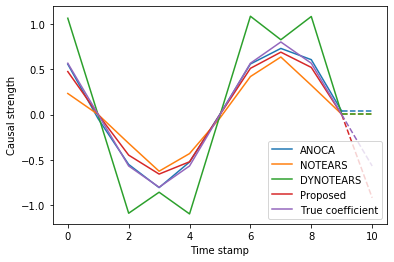

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
import numpy as np
fig, ax=plt.subplots(1)
d=pd.DataFrame({#'e':EDISON_list.mean(axis=0)[:,0,4],
                'e': np.append(result_ANOCA[:,1:,0,4].mean(axis=0),result_ANOCA[:,-1,0,4].mean(axis=0)),
                'd':np.append(result_NOTEARS[:,1:,0,4].mean(axis=0),mean(result_NOTEARS[:,-1,0,4])),
                'a':np.append(result_dynotears.mean(axis=0)[:,4,0],result_dynotears.mean(axis=0)[-1,4,0]),
                'b':exten_matrix.mean(axis=0)[:,0,4],
                'c':[cos(i+1) for i in range(time_stamp+1)]
               })
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_prop_cycle(cycler('color', colors[:5]))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(d[:-1],'-',d[-2:],'--')
plt.legend(["ANOCA","NOTEARS","DYNOTEARS","Proposed", "True coefficient",])
  
# function to show the plot
plt.xlabel("Time stamp")
plt.ylabel("Causal strength")
#plt.show()
plt.savefig("cos_lag.pdf")

In [74]:
MSE_list_proposed=[]
MSE_list_dynotears=[]
MSE_list_ANOCA=[]
MSE_list_NOTEARS=[]
for j in range(30):
    MSE_list_dynotears.append(mean((result_dynotears[j,:,4,0]-[cos(i+1)for i in range(10)])**2))
    MSE_list_proposed.append(mean((exten_matrix[j,:-1,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_ANOCA.append(mean((result_ANOCA[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))
    MSE_list_NOTEARS.append(mean((result_NOTEARS[j,1:,0,4]-[cos(i+1)for i in range(10)])**2))

In [75]:
import statistics
print("dynotears",round(mean(MSE_list_dynotears),2), round(statistics.pstdev(MSE_list_dynotears)/math.sqrt(30),3))
print("proposed",round(mean(MSE_list_proposed),2), round(statistics.pstdev(MSE_list_proposed)/math.sqrt(30),3))
print("ANOCA",round(mean(MSE_list_ANOCA),2), round(statistics.pstdev(MSE_list_ANOCA)/math.sqrt(30),3))
print("NOTEARS",round(mean(MSE_list_NOTEARS),2), round(statistics.pstdev(MSE_list_NOTEARS)/math.sqrt(30),3))

dynotears 0.15 0.004
proposed 0.02 0.009
ANOCA 0.07 0.007
NOTEARS 0.1 0.006


In [80]:
result_new=np.load("cos_gamma_constraint.npy")
result_cont=np.load("cos_gamma_constraint_cont.npy")
gamma_list=np.zeros((n_times,30,n_var))
gamma_list[:20,:,:]=result_new[:20,:,:]
gamma_list[20:,:,:]=result_cont[20:,:,:]
temp=np.load("cos_10_30_ANOCA_lag.npy")
result_ANOCA=np.load("cos_10_30_ANOCA_lag_cont.npy")
result_ANOCA[:,:-1,:,:]=temp
result_NOTEARS=np.load("cos_10_30_NOTEARS_lag.npy")

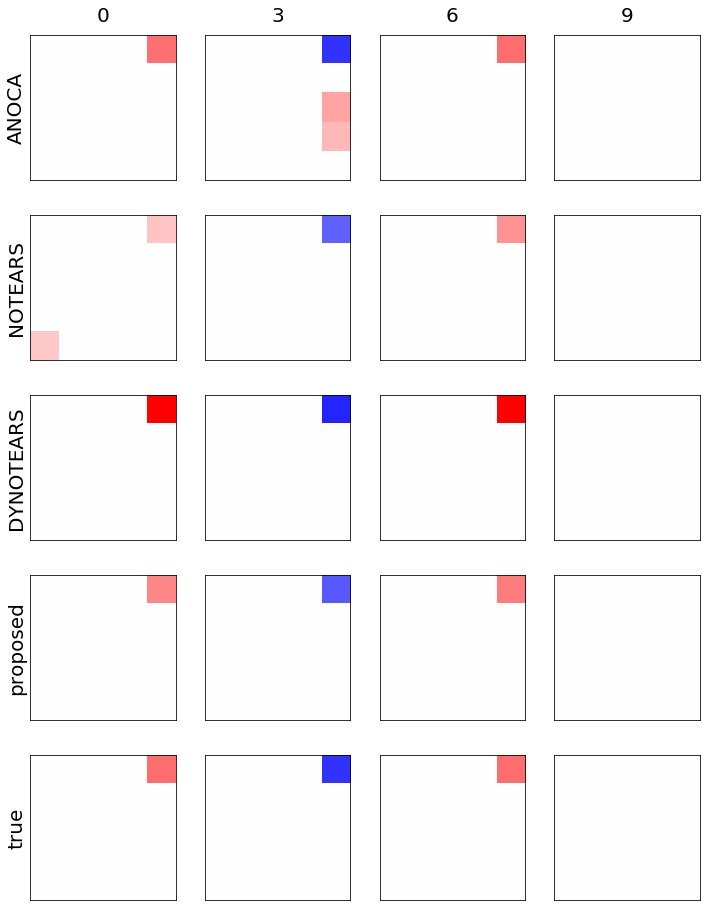

In [84]:
select_time=[0,3,6,9]
methods=["ANOCA","NOTEARS","DYNOTEARS","proposed","true"]
figure, axs = plt.subplots(nrows=5, ncols=4, figsize=(12, 16))
for i in range(len(select_time)):
    actual_time=select_time[i]
    ANOCA_graph=result_ANOCA[:,actual_time+1,:,:].mean(axis=0)
    ANOCA_graph[abs(ANOCA_graph)<0.2]=0
    axs[0, i].matshow(ANOCA_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    axs[0, i].set_title(str((select_time[i])),fontdict={'fontsize': 20})
    ##NOTEARS plot
    NOTEARS_graph=result_NOTEARS[:,actual_time+1,:,:].mean(axis=0)
    NOTEARS_graph[abs(NOTEARS_graph)<0.2]=0
    axs[1, i].matshow(NOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##DYNOTEARS plot
    DYNOTEARS_graph=result_dynotears[:,actual_time,:,:].mean(axis=0).T
    DYNOTEARS_graph[abs(DYNOTEARS_graph)<0.2]=0
    axs[2, i].matshow(DYNOTEARS_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##proposed plot
    proposed_graph=exten_matrix[:,actual_time,:,:].mean(axis=0)
    proposed_graph[abs(proposed_graph)<0.2]=0
    axs[3, i].matshow(proposed_graph, cmap = 'bwr', vmin = -1, vmax = 1)
    ##True plot
    true=np.zeros([5, 5])
    true[0,4]=cos(actual_time+1)
    true[abs(true)<0.2]=0
    axs[4, i].matshow(true, cmap = 'bwr', vmin = -1, vmax = 1)
for j in range(len(methods)):
    axs[j, 0].set(ylabel=methods[j])
    axs[j, 0].yaxis.label.set_size(20)
for i in range(5):
    for j in range(4):
        axs[i][j].get_xaxis().set_ticks([])
        axs[i][j].get_yaxis().set_ticks([])
plt.savefig("cos_lag_graph.pdf")